In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [4]:
# 1. Chargement des données

ds = xr.open_dataset("era5_t2m_2025_01-02_fr.nc")
var_name = "t2m"

# Shapefile France
france = gpd.read_file("../data/shapefiles/region.shp")

In [5]:
# 2. Température en °C

t2m = ds[var_name]  # (valid_time, latitude, longitude)
units = t2m.attrs.get("units", "")

if units in ["K", "kelvin"]:
    t2m_c = t2m - 273.15
    units_plot = "°C"
else:
    t2m_c = t2m
    units_plot = units

In [6]:
# 3. Moyenne NAÏVE (masque binaire)

# Coords
lats = ds["latitude"].values   # (n_lat,)
lons = ds["longitude"].values  # (n_lon,)

# France en WGS84 (lon/lat) pour le masque point-in-polygon
crs_ll = "EPSG:4326"
gdf_ll = france.to_crs(crs_ll)
france_poly_ll = gdf_ll.unary_union

# Grille des centres de pixels
lon2d, lat2d = np.meshgrid(lons, lats)  # (n_lat, n_lon)

# Points centres
points = [Point(x, y) for x, y in zip(lon2d.ravel(), lat2d.ravel())]

# Masque binaire (True = pixel dont le centre est en France)
mask_flat = np.array([france_poly_ll.contains(p) for p in points])
mask = mask_flat.reshape(lat2d.shape)  # (n_lat, n_lon)

# Appliquer le masque à la température (NaN hors France)
t2m_fr_naive = t2m_c.where(mask)

# Moyenne spatiale naïve à chaque instant (ignorer NaN)
t2m_mean_naive = t2m_fr_naive.mean(dim=("latitude", "longitude"))  # (valid_time,)

/tmp/ipykernel_48283/3512834357.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  france_poly_ll = gdf_ll.unary_union


In [7]:
# 4. Moyenne PONDÉRÉE (fraction de surface)

def compute_bounds(coords):
    """
    À partir des coordonnées des centres (1D), calcule les bords (1D) de longueur N+1.
    Marche que les coords soient croissantes ou décroissantes.
    """
    coords = np.asarray(coords)
    N = coords.size
    if N < 2:
        raise ValueError("Il faut au moins 2 points pour calculer des bounds.")

    mids = 0.5 * (coords[:-1] + coords[1:])  # milieux entre centres

    bounds = np.empty(N + 1, dtype=float)
    bounds[1:-1] = mids
    bounds[0] = coords[0] - (mids[0] - coords[0])
    bounds[-1] = coords[-1] + (coords[-1] - mids[-1])
    return bounds

nlat = len(lats)
nlon = len(lons)

lat_bnds = compute_bounds(lats)  # (n_lat + 1,)
lon_bnds = compute_bounds(lons)  # (n_lon + 1,)

# CRS projeté pour les aires
crs_proj = "EPSG:2154"  # Lambert 93

# France en Lambert 93
gdf_proj = france.to_crs(crs_proj)
france_poly_proj = gdf_proj.unary_union

weights = np.zeros((nlat, nlon), dtype=float)

for i in range(nlat):
    for j in range(nlon):
        # Polygone du pixel en lon/lat
        corners_ll = [
            (lon_bnds[j],   lat_bnds[i]),
            (lon_bnds[j+1], lat_bnds[i]),
            (lon_bnds[j+1], lat_bnds[i+1]),
            (lon_bnds[j],   lat_bnds[i+1]),
        ]
        cell_poly_ll = Polygon(corners_ll)

        # Projeter le polygone du pixel en Lambert 93
        cell_poly_gs = gpd.GeoSeries([cell_poly_ll], crs=crs_ll).to_crs(crs_proj)
        cell_poly_proj = cell_poly_gs.iloc[0]

        # Intersection avec la France
        inter = cell_poly_proj.intersection(france_poly_proj)

        if inter.is_empty:
            w_ij = 0.0
        else:
            w_ij = inter.area / cell_poly_proj.area  # fraction de surface du pixel dans la France

        weights[i, j] = w_ij

print("Poids - min:", weights.min(), "max:", weights.max(), "mean:", weights.mean())

# DataArray des poids
weights_da = xr.DataArray(
    weights,
    coords={"latitude": ds["latitude"], "longitude": ds["longitude"]},
    dims=("latitude", "longitude"),
    name="weights_france",
)

# Numérateur = somme(T * poids) sur l'espace
num = (t2m_c * weights_da).sum(dim=("latitude", "longitude"))

# Dénominateur = somme des poids (on ignore les pixels sans données si besoin)
den = weights_da.where(
    ~np.isnan(t2m_c.isel(valid_time=0))
).sum(dim=("latitude", "longitude"))

t2m_mean_weighted = num / den  # (valid_time,)

/tmp/ipykernel_48283/922451542.py:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  france_poly_proj = gdf_proj.unary_union


Poids - min: 0.0 max: 1.0000000000000004 mean: 0.3869137930138202


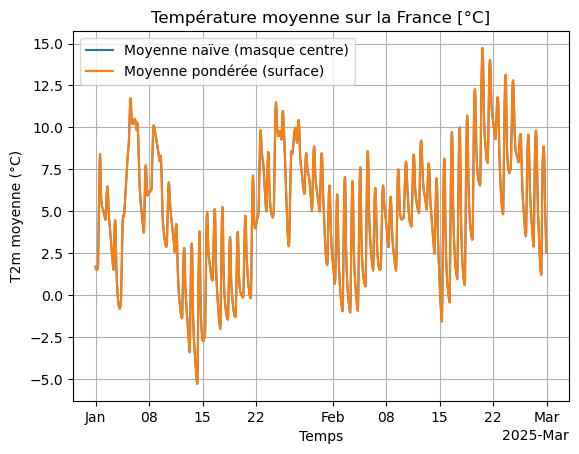

In [8]:
# 5. Comparaison des deux moyennes

plt.figure()
t2m_mean_naive.plot(label="Moyenne naïve (masque centre)")
t2m_mean_weighted.plot(label="Moyenne pondérée (surface)")
plt.title(f"Température moyenne sur la France [{units_plot}]")
plt.xlabel("Temps")
plt.ylabel(f"T2m moyenne ({units_plot})")
plt.grid(True)
plt.legend()
plt.show()

In [15]:
#t2m_mean_naive - t2m_mean_weighted
print(t2m_mean_weighted.mean())
print(t2m_mean_naive.mean())

<xarray.DataArray ()> Size: 8B
array(4.91637564)
Coordinates:
    number   int64 8B 0
<xarray.DataArray 't2m' ()> Size: 8B
array(4.91051674)
Coordinates:
    number   int64 8B ...


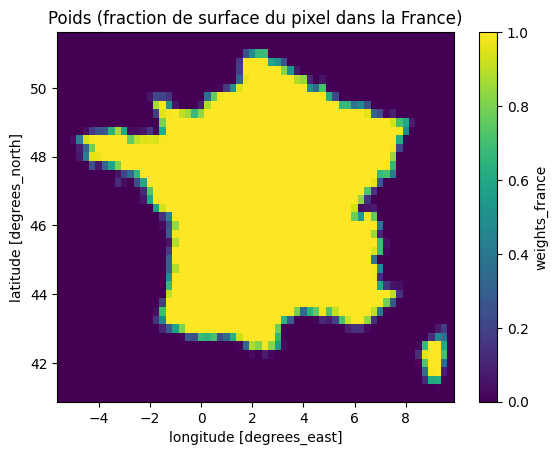

In [ ]:
# 6. Carte des poids

plt.figure()
weights_da.plot()
plt.title("Poids (fraction de surface du pixel dans la France)")
plt.show()